### California Housing Prices  

Dataset collected from the StatLib repository (based on data from the 1990 Caifornia Census. This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).


### GET THE DATA & BASIC INSPECTION

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
df = pd.read_csv(filename)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


#### By the looks of it, there are 20,640 data entries (records) in our dataset, and there are 10 independent variables. 

#### All of the metrics (x variables) are numerical variables except for the ocean_proximity (the only categorical variable here). 

#### All of the data points are non-null except for the records of total_bedrooms (with 207 missing data), which I will handle later.  

In [113]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [114]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


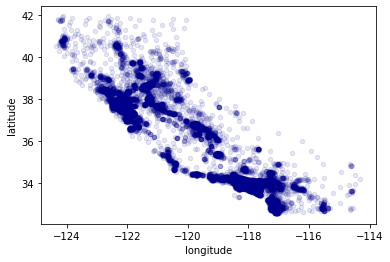

In [65]:
df.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1,color='darkblue')

#### We can tell from the scatterplot that there are certain areas that are denser in terms of the number of houses purchased (coastal areas, Southern California, ect)

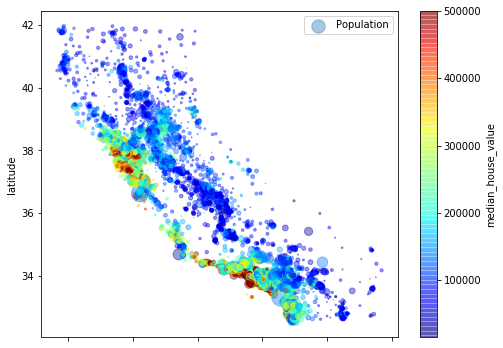

In [148]:
df.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
       s=df['population']/100, label='Population', figsize=(8,6),
       c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

plt.show()

#### From the color map above, the bigger the radius of the circle, the bigger population a district(area) has. 
#### We can see that along the coasts and where there are more people, there are more expensive houses. 

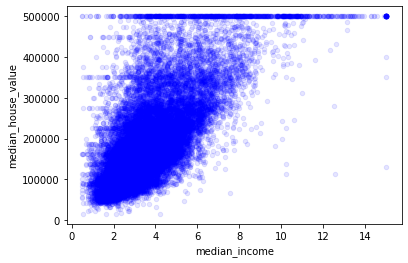

In [149]:
df.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1,color='blue')

# Median_income is capped at 15, which means that income that is more than 150,001 was not captured in this dataset
# Same for Median_house_value: housing prices are capped at $500,001 (max)

### Find the COR (Pearson R) between the attributes

In [115]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

#### The closer to 1 the absolute value of the coefficient is, the better it is as a predictor for our model. 
#### Here, median_house_value is 100% correlated to itself. Good predictors here could be median_income, total_rooms, housing_median_age.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119A6930>,
      dtype=object)

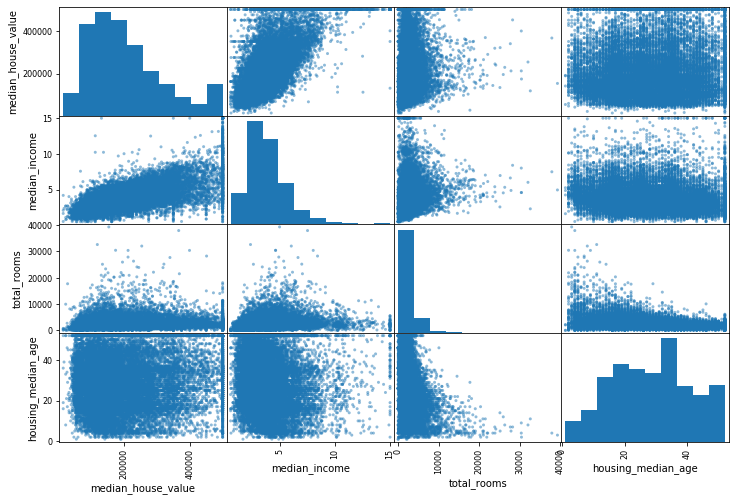

In [116]:
# Visualizing the results above

from pandas.plotting import scatter_matrix # which plots every numerical attribute against every other numerical attribute

attributes=['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(df[attributes],figsize=(12,8))


#### The diagonal histograms are just descriptions of the attribute itself. 

### Feature Extraction

In [117]:
# Let's create more variables based on what we've already got.

# First, let's create median_room_per_household 
df['median_room_per_household']=df['total_rooms']/df['households']

# Second,median_bedroom_per_hh
df['median_bedroom_per_room']=df['total_bedrooms']/df['total_rooms']

# Third and last, population per household
df['pop_per_household']=df['population']/df['households']

In [118]:
corr_matrix=df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.688075
median_room_per_household    0.151948
total_rooms                  0.134153
housing_median_age           0.105623
households                   0.065843
total_bedrooms               0.049686
pop_per_household           -0.023737
population                  -0.024650
longitude                   -0.045967
latitude                    -0.144160
median_bedroom_per_room     -0.255880
Name: median_house_value, dtype: float64

#### It seems like we've got to use this newly added feature 'Median_bedroom_per_room since the correlation is pretty high!

### Missing Data Handling

Fortunately, we only need to deal with one column with missing data, which is the 'Total_bedrooms' column

I am going to replace the missing data with the median of the variable

In [119]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(),inplace=True)
df['total_bedrooms'].isnull().sum()

df['median_bedroom_per_room'].fillna(df['median_bedroom_per_room'].median(),inplace=True)
df['median_bedroom_per_room'].isnull().sum()

0

### Handling Text/Categorical Variables

In our case, we have only one categorical variable, which is 'Ocean_proximity'

In [120]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [126]:
df['ocean_proximity']=df['ocean_proximity'].map({'NEAR BAY':0,'NEAR OCEAN':1,'INLAND':2,'ISLAND':3,'<1H OCEAN':4})
df['ocean_proximity'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: ocean_proximity, dtype: int64

In [150]:
# Final step before I go head and select a model: drop some unnecessary columns (variables)

df=df.drop(['pop_per_household','population'],axis=1) # These two both have only an absolute value of R=0.02. 
                                                    # which I already extracted and turned into new features, 
                                                    # so we can drop them now

### SELECT A MODEL

In [151]:
X = df.drop('median_house_value',axis=1)
y = df[['median_house_value']]

In [152]:
# Creat a test set and a train set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

X_train.shape,y_train.shape

((16512, 10), (16512, 1))

In [153]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,households,median_income,median_house_value,ocean_proximity,median_room_per_household,median_bedroom_per_room
0,-122.23,37.88,41.0,880.0,129.0,126.0,8.3252,452600.0,0,6.984127,0.146591
1,-122.22,37.86,21.0,7099.0,1106.0,1138.0,8.3014,358500.0,0,6.238137,0.155797
2,-122.24,37.85,52.0,1467.0,190.0,177.0,7.2574,352100.0,0,8.288136,0.129516
3,-122.25,37.85,52.0,1274.0,235.0,219.0,5.6431,341300.0,0,5.817352,0.184458
4,-122.25,37.85,52.0,1627.0,280.0,259.0,3.8462,342200.0,0,6.281853,0.172096


In [154]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)

### Now that we have trained our Regression model on the trainset, let's evaluate our model with MSE

In [155]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test,y_pred)))

71144.09369496546


In [156]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(lr,X_train,y_train,scoring='neg_mean_squared_error',cv=10) # 10 fold cross-validation
lr_rmse_scores=np.sqrt(-scores)

tree_rmse_scores # CrossVal on the Linear Regression model

array([74711.82879348, 72237.08124357, 72432.42308297, 67837.05014528,
       75386.84862445, 70372.24305627, 68157.75127441, 70194.89746902,
       76327.72121244, 68201.65021811])

My Regression model has the RMSE of 71,144. So on average, my model predicts the house prices with the error of 68k. :(

Let's try Decision Tree and see if it's going to be a better model or not. 

For this, we are using Cross Validation feature to better evaluate the Decision Tree algorithm for this prediction

### Try DecisionTree

In [157]:
from sklearn.tree import DecisionTreeRegressor

tree_reg=DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)

y_tree_pred = tree_reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,y_tree_pred)))

70193.60413409515


Looks like the DT model does not work so much better than the Linear Regression model. Let's apply Cross Validation Evaluation

In [158]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg,X_train,y_train,scoring='neg_mean_squared_error',cv=10) # 10 fold cross-validation
tree_rmse_scores=np.sqrt(-scores)

tree_rmse_scores # Cross Val on the DT model

array([73270.47495521, 74157.2092424 , 73653.17605584, 68203.59582001,
       76803.14529526, 72469.56065809, 70065.64940947, 70037.04144409,
       72770.29054831, 68714.61400684])

### Let's try one last time with RandomForest

In [159]:
from sklearn.ensemble import RandomForestRegressor
forest_reg=RandomForestRegressor()
forest_reg.fit(X_train,y_train)

y_forest_pred=forest_reg.predict(X_test)

c:\users\tram ngo\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\tram ngo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [160]:
rmse_forest=np.sqrt(mean_squared_error(y_test,y_forest_pred))
rmse_forest

51415.96430424782

In [161]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,y_forest_pred))# One of the key differences between the RMSE and MAE evaluation metrics is 
                                        # that the latter is not affected as much by outliers, meaning that if my testset
                                        # has a lot of outliers, I would want to use MAE as my performance evaluation.

34028.81940406977


Here, it appears that the test set contains a lot of outliers since the difference between the RMSE and MAE is big.

#### Out of the three algorithms, it looks like RandomForest works the best for the dataset and the features we've got.